# Exercise 04

# Task 01: Setting up the development environment

After following instructions on the worksheet, execute the following python cell:

In [93]:
import spyder
import os, sys
import mesa
# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# check python version
print("Python version: ", sys.version)

# check spyder
print("Spider version: ", spyder.__version__)

# check git
os.system('git --version')

Python version:  3.11.6 (main, Oct  2 2023, 13:45:54) [Clang 15.0.0 (clang-1500.0.40.1)]
Spider version:  5.5.4
git version 2.43.0


0

# Task 02: Mesa tutorial

In [94]:
# Place the tutorial execution commands here:

In [95]:
from task03.Money_Tutorial import MoneyModel

model = MoneyModel(100, 10, 10) # N == number of agents, width, height
for i in range(20):
    model.step()


# Histogram: Wealth distribution

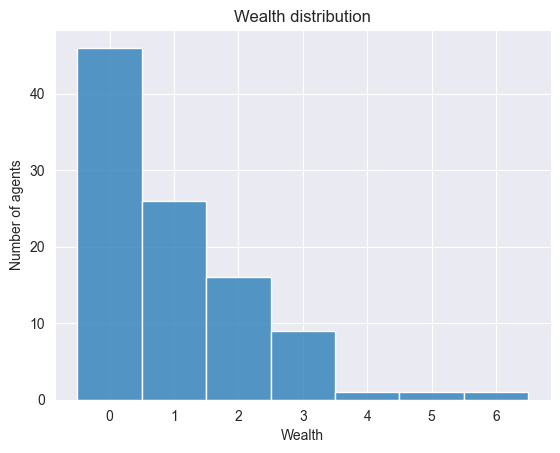

In [96]:
agent_wealth = [a.wealth for a in model.schedule.agents]
# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(
    title="Wealth distribution", xlabel="Wealth", ylabel="Number of agents"
);  # The semicolon is just to avoid printing the object representation

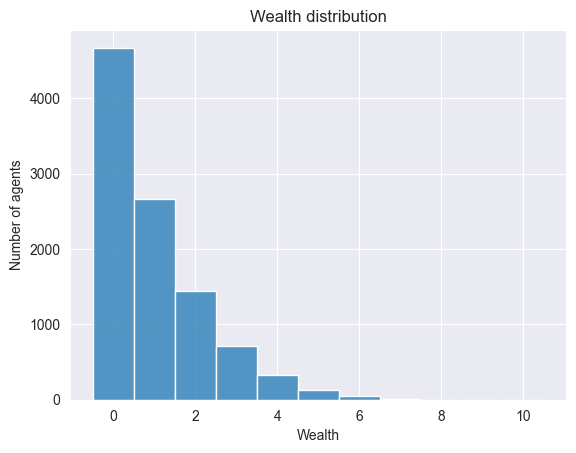

In [97]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(100, 10, 10) # init new model
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth) # wealth after 10 steps

# Use seaborn
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="Number of agents");

# Heatmap: position of agents

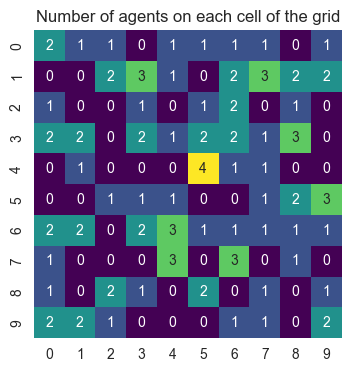

In [98]:
agent_counts = np.zeros((model.grid.width, model.grid.height))  # grid represents number of agents in position
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content) # len of list of agents in cell
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");

# Line graph: gini coefficient over time

In [99]:
model = MoneyModel(100, 10, 10) # N == number of agents, width, height
for i in range(100):    # 100 steps
    model.step()

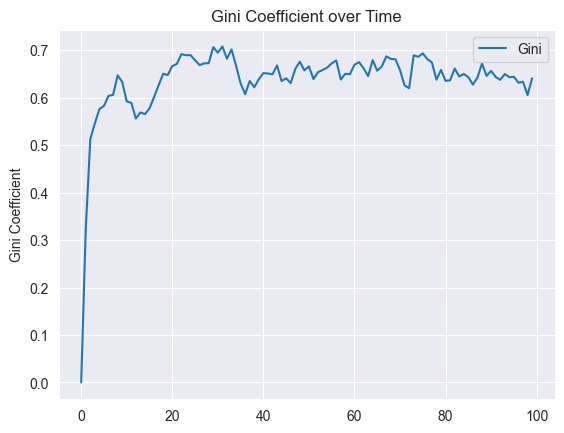

In [100]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

# Dataframe: collection of data (wealth per agent and step)

In [101]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth  Steps_not_given
Step AgentID                         
0    0             1                0
     1             1                0
     2             1                0
     3             1                0
     4             1                0

# Histogram: distribution of wealth at end of time

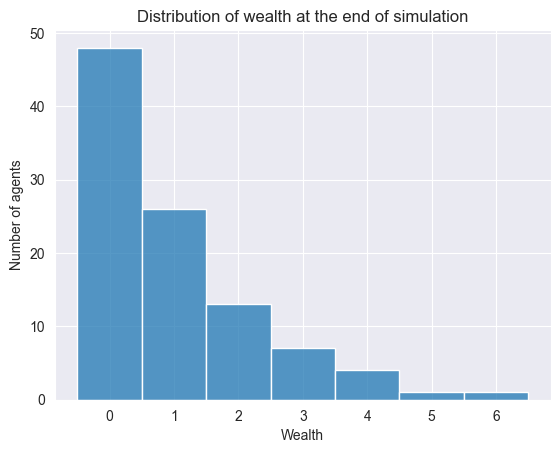

In [102]:
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="Number of agents",
);

# Line plot: Wealth of one agent over time

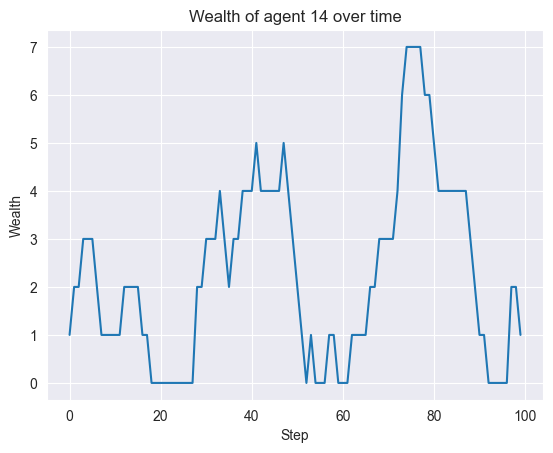

In [103]:
# Get the wealth of agent 14 over time
one_agent_wealth = agent_wealth.xs(14, level="AgentID")

# Plot the wealth of agent 14 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 14 over time");

# Line plot: Wealth of three agents over time

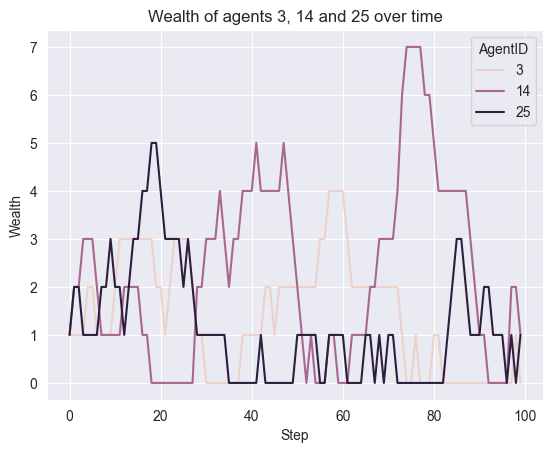

In [104]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

# Line plot with confidence interval: Average wealth with 95% confidence interval for that wealth

[Text(0.5, 1.0, 'Average wealth over time')]

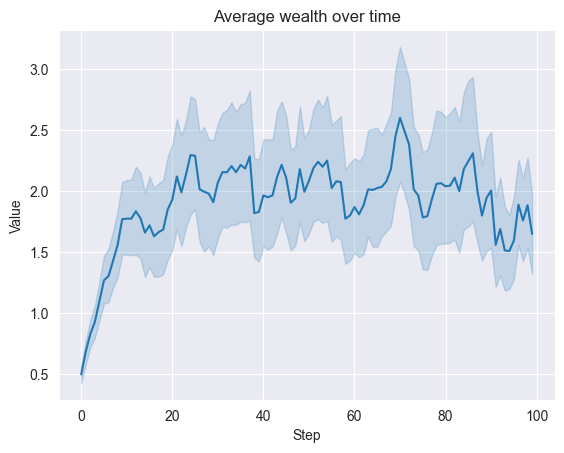

In [105]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

# Save data as .csv file

In [106]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

# Batches

In [107]:
params = {"width": 10, "height": 10, "N": range(5, 100, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=7,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/133 [00:00<?, ?it/s]

In [108]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth', 'Steps_not_given'],
      dtype='object')


# Scatter plot: Gini coefficient with respect to number of agents
It is sufficient to look at one agent bc gini coefficient is the same for whole population.

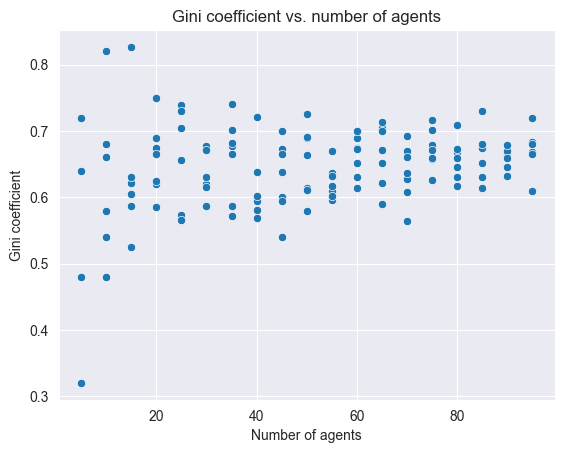

In [109]:
# Filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
results_filtered[["iteration", "N", "Gini"]].reset_index(
    drop=True
).head()  # Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="N", y="Gini")
g.set(
    xlabel="Number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

# point plot: Gini coefficient with respect to number of agents

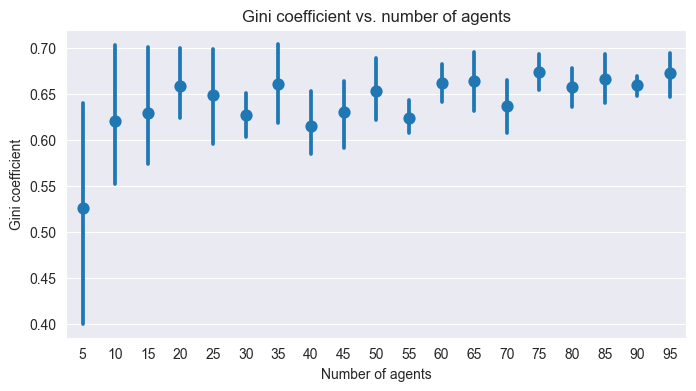

In [110]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x="N", y="Gini", linestyle='none')
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="Number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

# print part of dataframe

In [111]:
results_df

,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth,Steps_not_given
0,0,0,0,10,10,5,0.000000,0,1,0
1,0,0,0,10,10,5,0.000000,1,1,0
2,0,0,0,10,10,5,0.000000,2,1,0
3,0,0,0,10,10,5,0.000000,3,1,0
4,0,0,0,10,10,5,0.000000,4,1,0
...,...,...,...,...,...,...,...,...,...,...
671645,132,6,100,10,10,95,0.680997,69,1,5
671646,132,6,100,10,10,95,0.680997,87,0,8
671647,132,6,100,10,10,95,0.680997,78,1,0
671648,132,6,100,10,10,95,0.680997,46,2,0


In [112]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=10
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter Notebook
# from IPython.display import display, HTML
# display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
  ...      ...     ...
  100        0       2
  100        2       2
  100        7       0
  100        4       1
  100        5       0


In [113]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=10))


 Step  Gini
    0  0.00
    1  0.18
    2  0.34
    3  0.18
    4  0.32
  ...   ...
   96  0.54
   97  0.58
   98  0.58
   99  0.58
  100  0.54


# Run batch and filter data for one agent

In [114]:
params = {"width": 10, "height": 10, "N": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=100,
    max_steps=120,
    number_processes=1,
    data_collection_period=1,  # Important, otherwise the datacollector will only collect data of the last time step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

  0%|          | 0/500 [00:00<?, ?it/s]

In [115]:
# Again filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time)
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 0)]
results_5s_df_filtered.head(3)

,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth,Steps_not_given
0,0,0,0,10,10,5,0.00,0,1,0
9,0,0,1,10,10,5,0.00,0,1,1
12,0,0,2,10,10,5,0.32,0,2,2


# Line plot: Gini coefficient for different population sizes

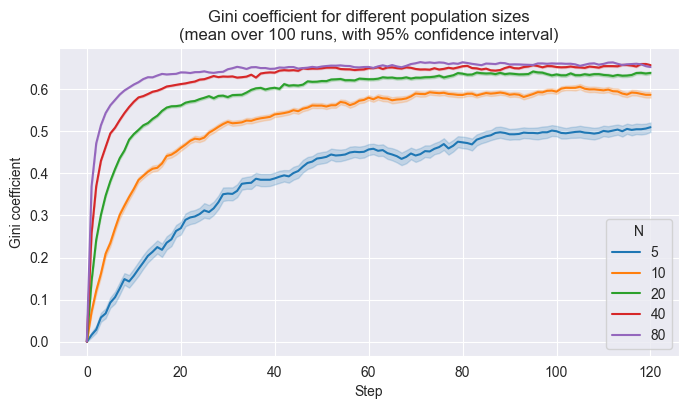

In [116]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="N",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plot_title = "Gini coefficient for different population sizes\n(mean over 100 runs, with 95% confidence interval)"
g.set(title=plot_title, ylabel="Gini coefficient");

# Use group by to calculate mean of wealth and steps_not_given (Dataframe)

In [117]:
# Calculate the mean of the wealth and the number of consecutive rounds for all agents in each episode
agg_results_df = (
    results_5s_df.groupby(["iteration", "N", "Step"])
    .agg({"Wealth": "mean", "Steps_not_given": "mean"})
    .reset_index()
)
agg_results_df.head(3)

,iteration,N,Step,Wealth,Steps_not_given
0,0,5,0,1.0,0.0
1,0,5,1,1.0,1.0
2,0,5,2,1.0,1.6


# Line plot: average number of rounds without transaction w.r.t. steps for different population size

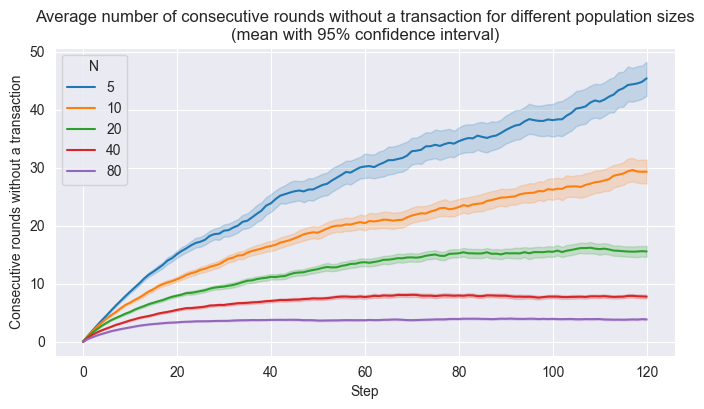

In [118]:
# Create a line plot with error bars
g = sns.lineplot(
    data=agg_results_df, x="Step", y="Steps_not_given", hue="N", palette="tab10"
)
g.figure.set_size_inches(8, 4)
g.set(
    title="Average number of consecutive rounds without a transaction for different population sizes\n(mean with 95% confidence interval)",
    ylabel="Consecutive rounds without a transaction",
);